In [1]:
# import packages
import pandas as pd
import numpy as np
import pickle
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from sklearn.pipeline import Pipeline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# load test data
input_path = 'H:\RediMinds\VCQI'
#train = pd.read_csv(input_path+"\VCQI_clean_train.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test.csv")

In [5]:
test.drop(labels=['PATIENTNUMBER'], inplace=True, axis=1)

In [6]:
#x_train = train.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
#y_train = train['INTRA_OP_COMPLICATIONS'].copy()
x_test = test.drop(labels='INTRA_OP_COMPLICATIONS', axis = 'columns').copy()
y_test = test['INTRA_OP_COMPLICATIONS'].copy() 

In [7]:
# check % of pos labels in test set
#print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

% pos labels test 0.06


In [8]:
# Generate prediction for the Random Forest Model
with open (input_path+'\cat_col', 'rb') as fp:
    cat_col = pickle.load(fp)

model_path = 'output/models/'
from joblib import load
encoder = load(model_path+'OHE.joblib')

In [9]:
# Create dummy variables
one_hot_encoded_array = encoder.transform(x_test[cat_col]).toarray()
column_name = encoder.get_feature_names(cat_col)
x_test_OHE =  pd.DataFrame(one_hot_encoded_array, columns= column_name)
x_test = x_test.merge(x_test_OHE, how = 'left', left_index = True, right_index =True) # create dummy variables
x_test = x_test.drop(labels = cat_col, axis = 'columns') # drop original variables

### Load Models

In [10]:
model_path = 'output/models/'

In [11]:
# import Decision Tree Classifier
from joblib import load
DTC = load(model_path+'DTC.joblib')


In [12]:
# import Random Forest Classifer
from joblib import load
RFR = load(model_path+'RFR.joblib')

In [13]:
# import Random Forest Classifer
from joblib import load
Logit = load(model_path+'Logit.joblib')

In [14]:
# load Neural Network Model
from joblib import load
# Load the pipeline first:
pipeline = load(model_path+'nn_pipeline.pkl')

# Then, load the Keras model:
pipeline_model = keras.models.load_model(model_path+'nn_model.h5')

nn_model = Pipeline(steps=[('preprocessor', pipeline),
                ('classifier',pipeline_model)
               ])

### Generate Predictions for the Test set

In [15]:
# Generate prediction for the Decsiion Tree Model
results_DTC = pd.DataFrame(DTC.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(DTC.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [16]:
# Generate prediction for the Random Forest Model
results_RFR = pd.DataFrame(RFR.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(RFR.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [17]:

# Generate prediction for the Logitic Regressions Model
results_Logit = pd.DataFrame(Logit.predict(x_test), columns=['pred_label'])
results_Logit['pred_prob'] =  pd.DataFrame(Logit.predict_proba(x_test))[1]
results_Logit['true_label'] = np.array(y_test)

In [18]:
# Generate prediction for Neural Network Model

# Generate prediction for the Neural Network Model
results_NN = pd.DataFrame(nn_model.predict(x_test), columns=['pred_prob'])
results_NN['pred_label'] =  results_NN['pred_prob'].apply(lambda x: 1 if x>=0.5 else 0)
results_NN['true_label'] = np.array(y_test)

### Performance of the models for the testset

In [19]:
# Define function to calculate Precision-Recall Curve
def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc


print("AUC-ROC DTC: {:.3f}".format(metrics.roc_auc_score(results_DTC['true_label'], results_DTC['pred_prob'])))
print("AUC-ROC LOGIT: {:.3f}".format(metrics.roc_auc_score(results_Logit['true_label'], results_Logit['pred_prob'])))
print("AUC-ROC RFR: {:.3f}".format(metrics.roc_auc_score(results_RFR['true_label'], results_RFR['pred_prob'])))
print("AUC-ROC NN: {:.3f}".format(metrics.roc_auc_score(results_NN['true_label'], results_NN['pred_prob'])))


print("PR-AUC DTC: {:.3f}".format(calc_aucpr_data(results_DTC)))
print("PR-AUC LOGIT: {:.3f}".format(calc_aucpr_data(results_Logit)))
print("PR-AUC RFR: {:.3f}".format(calc_aucpr_data(results_RFR)))
print("PR-AUC NN: {:.3f}".format(calc_aucpr_data(results_NN)))

AUC-ROC DTC: 0.752
AUC-ROC LOGIT: 0.857
AUC-ROC RFR: 0.825
AUC-ROC NN: 0.868
PR-AUC DTC: 0.596
PR-AUC LOGIT: 0.391
PR-AUC RFR: 0.585
PR-AUC NN: 0.448


C:\Users\anubhav\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:85: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


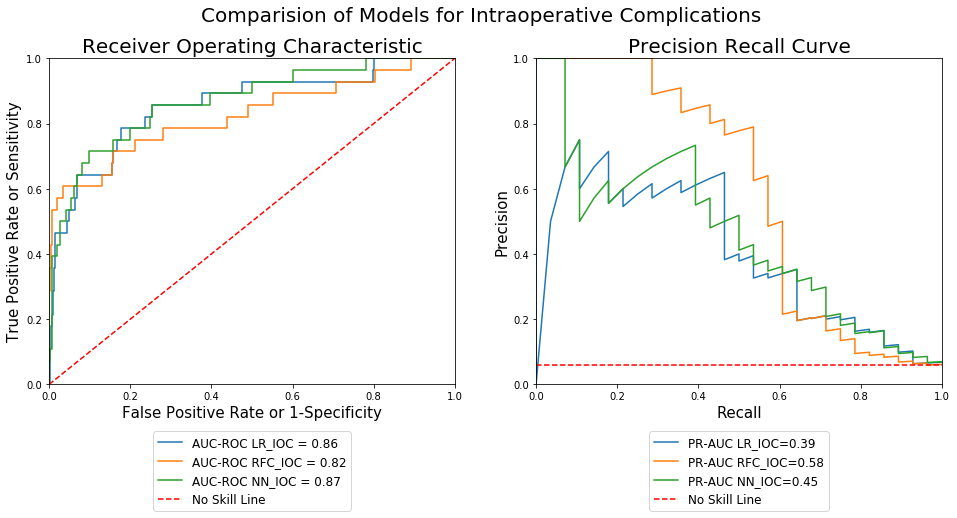

In [26]:
%matplotlib inline

# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    mortality_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, mortality_ratio

### Calculate metrics for models trained on original data
#fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
fpr_Logit, tpr_Logit, thresholds_Logit, roc_auc_Logit = calc_aucroc_data(results_Logit)
fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
fpr_NN, tpr_NN, thresholds_NN, roc_auc_NN = calc_aucroc_data(results_NN)

#recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, mortality_ratio = calc_aucpr_data(results_DTC)
recall_Logit, precision_Logit, f1_Logit, prc_auc_Logit, mortality_ratio = calc_aucpr_data(results_Logit)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, mortality_ratio = calc_aucpr_data(results_RFR)
recall_NN, precision_NN, f1_NN, prc_auc_NN, mortality_ratio = calc_aucpr_data(results_NN)

### Calculate metrics for models trained on SMOTE imputed data
#fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_SMOTE_DTC)
#fpr_s_Logit, tpr_s_Logit, thresholds_s_Logit, roc_auc_s_Logit = calc_aucroc_data(results_SMOTE_Logit)
#fpr_s_RFR,   tpr_s_RFR,   thresholds_s_RFR,   roc_auc_s_RFR   = calc_aucroc_data(results_SMOTE_RFR)
#fpr_s_NN,    tpr_s_NN,    thresholds_s_NN,    roc_auc_s_NN    = calc_aucroc_data(results_SMOTE_NN)

#recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, mortality_ratio = calc_aucpr_data(results_SMOTE_DTC)
#recall_s_Logit, precision_s_Logit, f1_s_Logit, prc_auc_s_Logit, mortality_s_ratio = calc_aucpr_data(results_SMOTE_Logit)
#recall_s_RFR,   precision_s_RFR,   f1_s_RFR,   prc_auc_s_RFR,   mortality_s_ratio = calc_aucpr_data(results_SMOTE_RFR)
#recall_s_NN,    precision_s_NN,    f1_s_NN,    prc_auc_s_NN,    mortality_s_ratio = calc_aucpr_data(results_SMOTE_NN)

# Plotting performance of models developed using original data
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Comparision of Models for Intraoperative Complications', fontsize=20, y=1)

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})

#ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC-ROC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_Logit, tpr_Logit, label = 'AUC-ROC LR_IOC = %0.2f' % roc_auc_Logit)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC-ROC RFC_IOC = %0.2f' % roc_auc_RFR)
ax1.plot(fpr_NN, tpr_NN, label = 'AUC-ROC NN_IOC = %0.2f' % roc_auc_NN)
#ax1.plot(fpr_s_Logit, tpr_s_Logit, label = 'AUC-ROC SMOTE_LR_IOC = %0.2f' % roc_auc_s_Logit)
#ax1.plot(fpr_s_RFR, tpr_s_RFR, label = 'AUC-ROC SMOTE_RFC_IOC = %0.2f' % roc_auc_s_RFR)
#ax1.plot(fpr_s_NN, tpr_s_NN, label = 'AUC-ROC SMOTE_NN_IOC = %0.2f' % roc_auc_s_NN)

ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})

#ax2.plot(recall_DTC, precision_DTC, label = 'PR-AUC DTC=%.2f' % (prc_auc_DTC))
ax2.plot(recall_Logit, precision_Logit, label = 'PR-AUC LR_IOC=%.2f' % (prc_auc_Logit))
ax2.plot(recall_RFR, precision_RFR, label = 'PR-AUC RFC_IOC=%.2f' % (prc_auc_RFR))
ax2.plot(recall_NN, precision_NN, label = 'PR-AUC NN_IOC=%.2f' % (prc_auc_NN))
#ax2.plot(recall_s_Logit, precision_s_Logit, label = 'PR-AUC SMOTE_LR_IOC=%.2f' % (prc_auc_s_Logit))
#ax2.plot(recall_s_RFR, precision_s_RFR, label = 'PR-AUC SMOTE_RFC_IOC=%.2f' % (prc_auc_s_RFR))
#ax2.plot(recall_s_NN, precision_s_NN, label = 'PR-AUC SMOTE_NN_IOC=%.2f' % (prc_auc_s_NN))
positive_class_ratio = mortality_ratio
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)
fig.show()



C:\Users\anubhav\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


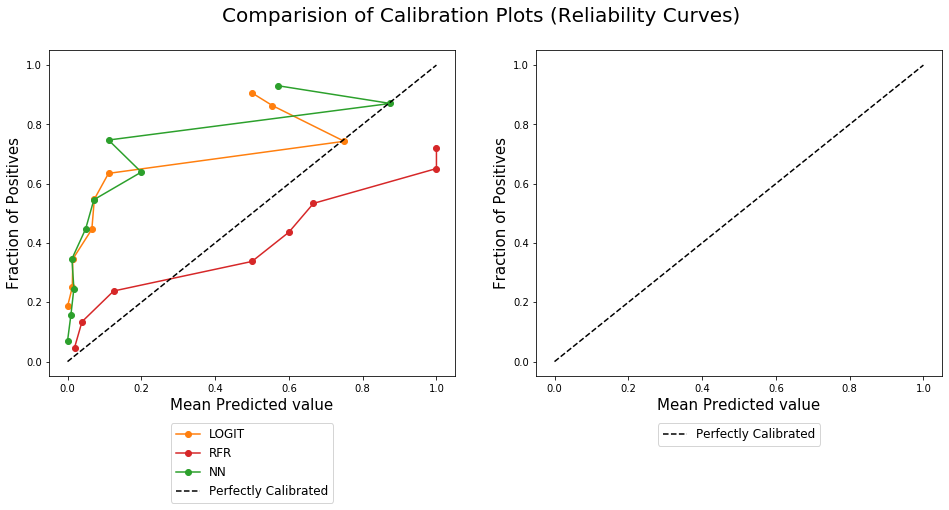

In [92]:
# Plotting Calibration curve
from sklearn.calibration import calibration_curve

def calib_curve(result):
    x, y = calibration_curve(result['true_label'],result['pred_prob'],n_bins = 10, strategy='uniform')
    return x, y

x_DTC, y_DTC = calib_curve(results_DTC)
x_Logit, y_Logit = calib_curve(results_Logit)
x_RFR, y_RFR = calib_curve(results_RFR)
x_NN, y_NN = calib_curve(results_NN)

#x_SMOTE_DTC, y_SMOTE_DTC = calib_curve(results_SMOTE_DTC)
#x_SMOTE_Logit, y_SMOTE_Logit = calib_curve(results_SMOTE_Logit)
#x_SMOTE_RFR, y_SMOTE_RFR = calib_curve(results_SMOTE_RFR)
#x_SMOTE_NN, y_SMOTE_NN = calib_curve(results_SMOTE_NN)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle('Comparision of Calibration Plots (Reliability Curves)', fontsize=20)

#ax1.plot(x_DTC, y_DTC, marker = 'o', color = 'tab:blue', label = 'DTC')
ax1.plot(x_Logit, y_Logit, marker = 'o', color = 'tab:orange', label = 'LOGIT')
ax1.plot(x_RFR, y_RFR, marker = 'o', color = 'tab:red', label = 'RFR')
ax1.plot(x_NN, y_NN, marker = 'o', color = 'tab:green', label = 'NN')

ax1.plot([0, 1], [0, 1],linestyle='--',color='black', label = 'Perfectly Calibrated')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)
ax1.set_ylabel('Fraction of Positives',fontdict={"size":15})
ax1.set_xlabel('Mean Predicted value',fontdict={"size":15})

#ax2.plot(x_SMOTE_DTC, y_SMOTE_DTC, marker = 'o', color = 'tab:blue', label = 'DTC_SMOTE')
#ax2.plot(x_SMOTE_Logit, y_SMOTE_Logit, marker = 'o', color = 'tab:orange', label = 'LOGIT_SMOTE')
#ax2.plot(x_SMOTE_RFR, y_SMOTE_RFR, marker = 'o', color = 'tab:red', label = 'RFR_SMOTE')
#ax2.plot(x_SMOTE_NN, y_SMOTE_NN, marker = 'o', color = 'tab:green', label = 'NN_SMOTE')

ax2.plot([0, 1], [0, 1],linestyle='--',color='black', label = 'Perfectly Calibrated')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)
ax2.set_ylabel('Fraction of Positives',fontdict={"size":15})
ax2.set_xlabel('Mean Predicted value',fontdict={"size":15})

fig.show()

### Create bootstrapped confidence intervals for each model

In [93]:
def bootstrapped_AUC(result):
    """
    This function can be used to create bootstrapped estimate of AUCROC and PRAUC
    The input for this funtion is a dataframe with following variables.
    
    Variables in dataframe
    ----------------------
    true_label : True label of testset
    
    pred_prob : The predicted probability
    
    pred_label : The predicted label
    """
    from sklearn.utils import resample
    #from tqdm import tqdm

    n_iter = 10000
    roc_auc = list()
    prc_auc = list()


    for i in range(n_iter):
        result_sample = resample(result, n_samples = len(result),random_state=i)
        #Calculating AUROC for each sample
        y_ACTUAL= result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
        roc_auc.append(metrics.auc(fpr, tpr))

        #calculate AUPRC for each sample
        y_ACTUAL = result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        yhat = result_sample['pred_label']
        precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
        prc_auc.append(metrics.auc(recall,precision))
    
    return roc_auc, prc_auc

In [94]:
%%time
# Create bootstrapped estimates of AUCROC and PR
roc_auc_LR, pr_auc_LR  = bootstrapped_AUC(results_Logit)
roc_auc_RFR, pr_auc_RFR  = bootstrapped_AUC(results_RFR)
roc_auc_NN, pr_auc_NN  = bootstrapped_AUC(results_NN)
#roc_auc_SMOTE_LR, pr_auc_SMOTE_LR  = bootstrapped_AUC(results_SMOTE_Logit)
#roc_auc_SMOTE_RFR, pr_auc_SMOTE_RFR  = bootstrapped_AUC(results_SMOTE_RFR)
#roc_auc_SMOTE_NN, pr_auc_SMOTE_NN  = bootstrapped_AUC(results_SMOTE_NN)

Wall time: 1min 47s


In [95]:
dict_AUCROC = {'roc_auc_LR': roc_auc_LR,
               'roc_auc_RFR': roc_auc_RFR,
               'roc_auc_NN': roc_auc_NN,
               #'roc_auc_SMOTE_LR' : roc_auc_SMOTE_LR,
               #'roc_auc_SMOTE_RFR': roc_auc_SMOTE_RFR,
               #'roc_auc_SMOTE_NN' : roc_auc_SMOTE_NN
              }

dict_PRAUC = {'pr_auc_LR': pr_auc_LR,
               'pr_auc_RFR': pr_auc_RFR,
               'pr_auc_NN': pr_auc_NN,
               #'pr_auc_SMOTE_LR' : pr_auc_SMOTE_LR,
               #'pr_auc_SMOTE_RFR': pr_auc_SMOTE_RFR,
               #'pr_auc_SMOTE_NN' : pr_auc_SMOTE_NN
              }
df_AUCROC = pd.DataFrame(dict_AUCROC)
df_PRAUC = pd.DataFrame(dict_PRAUC)

In [96]:
df_AUCROC.head()

,roc_auc_LR,roc_auc_RFR,roc_auc_NN
0,0.903695,0.839370,0.900659
1,0.863853,0.853713,0.879064
2,0.852315,0.846142,0.868364
3,0.907098,0.878318,0.914554
4,0.794753,0.771296,0.815432


In [97]:
df_PRAUC.head()

,pr_auc_LR,pr_auc_RFR,pr_auc_NN
0,0.498662,0.605026,0.568219
1,0.325935,0.634333,0.475849
2,0.580101,0.684353,0.604137
3,0.404316,0.610898,0.458751
4,0.400440,0.521954,0.503890


In [98]:
# Print Confidence intervals for AUCROC
x = df_AUCROC.describe(percentiles=[0.025,0.975])
for i in df_AUCROC.columns:
    print(i+' 95%CI: {:.3f} (95% CI {:.3f},{:.3f})'.format(x[i]['mean'], x[i]['2.5%'], x[i]['97.5%']))

roc_auc_LR 95%CI: 0.858 (95% CI 0.766,0.931)
roc_auc_RFR 95%CI: 0.825 (95% CI 0.717,0.919)
roc_auc_NN 95%CI: 0.869 (95% CI 0.785,0.938)


In [99]:
# Print Confidence intervals for PRAUC
x = df_PRAUC.describe(percentiles=[0.025,0.975])
for i in df_PRAUC.columns:
    print(i+' 95%CI: {:.3f} (95% CI {:.3f},{:.3f})'.format(x[i]['mean'], x[i]['2.5%'], x[i]['97.5%']))

pr_auc_LR 95%CI: 0.407 (95% CI 0.217,0.611)
pr_auc_RFR 95%CI: 0.585 (95% CI 0.394,0.756)
pr_auc_NN 95%CI: 0.451 (95% CI 0.254,0.647)


### Bootsrap Hypothesis Testing

In [100]:
from sklearn.utils import resample
def calculate_roc_auc(result):
    #Calculating AUROC for each sample
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    #calculate AUPRC for each sample
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return roc_auc, prc_auc

In [101]:
def permutaion_diff(x, y):
    """
    This function creates a combined dataset under null hypothesis that there is no 
    difference between AUROC and PRAUC, of x and y.
    10000 samples are taken from combined dataset of length x, y respectively and the
    difference in AUCROC and PRROC is caulcated. 
    
    """
    # Combining the results of both algorithms under assumption that there is no difference between the results
    combined = pd.concat([x, y], sort = True)

    # Draw 10000 samples from combined dataset for each of length x and y where x, y are results of agorithms being tested
    # Calculate difference between the permuted sets


    dif_bootstrap_auc = []
    dif_bootstrap_prauc = []

    for i in range(10000):
        np.random.seed(i)
        perms_auroc_x, perms_prauc_x = calculate_roc_auc(resample(combined, n_samples = len(x)))
        perms_auroc_y, perms_prauc_y = calculate_roc_auc(resample(combined, n_samples = len(y)))
        dif_bootstrap_auc.append(perms_auroc_x-perms_auroc_y)
        dif_bootstrap_prauc.append(perms_prauc_x - perms_prauc_y)
    return dif_bootstrap_auc, dif_bootstrap_prauc

In [116]:
def permutaion_pvalue(x,y, bootstrap_diff,metric):
    """
    This function will take the x,y and calculate observed difference in metric.
    Check likelihood of getting the observed diff againt bootstrapped diff and provide p_value.
    If bootstrap_diff contains diff of AUC-ROC values then select metric as 'AUCROC'.
    If bootstrap_diff contains diff of PR-AUC values then select metric as 'PRAUC'.
    """
    
    if metric == 'AUCROC':
        metric = 0
    else: 
        metric = 1
    
    # Check the likelihood of getting observed differewnce in AUCROC and PRAUC
    obs_difs = (calculate_roc_auc(x)[metric] - calculate_roc_auc(y)[metric])
    #print('observed difference : {}'.format(obs_difs))
    p_value = sum(bootstrap_diff >= obs_difs)/10000
    #print('p-value: {}'.format(p_value))
    return obs_difs, p_value

In [117]:
def permutation_test(x,y):
    """
    This esxecutes permutaion test to check if diff in AUCROC and PRAUC of two classifiers is significant
    """
    dif_bootstrap_auc, dif_bootstrap_prauc = permutaion_diff(x,y)
    obs_difs_AUCROC, p_value_AUCROC = permutaion_pvalue(x,y,dif_bootstrap_auc, metric = 'AUCROC')
    obs_difs_PRAUC, p_value_PRAUC = permutaion_pvalue(x,y,dif_bootstrap_prauc, metric = 'PRAUC')
    return [obs_difs_AUCROC, obs_difs_PRAUC, p_value_AUCROC, p_value_PRAUC]

In [121]:
perm_stats = {'RFR_LR' : permutation_test(x = results_RFR, y = results_Logit),
              'RFR_NN' : permutation_test(x = results_RFR, y = results_NN),
              'LR_RFR' : permutation_test(x = results_Logit, y = results_RFR),
              'NN_RFR' : permutation_test(x = results_NN, y = results_RFR),
              'NN_LR'  : permutation_test(x = results_NN, y = results_Logit),
              'LR_NN'  : permutation_test(x = results_Logit, y = results_NN)
}

In [122]:
df_perm_stats = pd.DataFrame(perm_stats, index=['obs_difs_AUCROC',
                                               'obs_difs_PRAUC',
                                               'p_value_AUCROC',
                                               'p_value_PRAUC'])

In [123]:
df_perm_stats

,RFR_LR,RFR_NN,LR_RFR,NN_RFR,NN_LR,LR_NN
obs_difs_AUCROC,-0.032434,-0.043767,0.032434,0.043767,0.011333,-0.011333
obs_difs_PRAUC,0.193721,0.136720,-0.193721,-0.136720,0.057001,-0.057001
p_value_AUCROC,0.668000,0.726200,0.342800,0.286400,0.424000,0.576000
p_value_PRAUC,0.084200,0.162200,0.917400,0.839900,0.345700,0.654100


In [63]:
pwd

'C:\\Users\\anubhav\\Documents\\GitHub\\Partial-Nephrectomy\\Intra-op Complications'

In [64]:
RFR_FI = pd.DataFrame(RFR.best_estimator_.feature_importances_.tolist(), index=x_test.columns, columns= ['importance']).reset_index()

In [65]:
RFR_FI.sort_values(by = 'importance', ascending=False)

,index,importance
19,CENTERCODE_10,0.048643
1,BMI,0.042568
5,PREOPHT,0.042348
6,PREOPWBC,0.041051
0,AGEATSURGERY,0.035772
...,...,...
99,CT_5,0.000000
61,SIDEOFSURGERY_2,0.000000
72,PADUARISK_0,0.000000
48,SOLITARYKIDNEY_0,0.000000


In [66]:
import re
import string
re.sub('_\d{1,3}','','CT_4')

'CT'

In [67]:
RFR_FI['index'] = RFR_FI['index'].apply(lambda x: re.sub('_\d{1,3}','',x)).copy()

In [72]:
RFR_FI = RFR_FI.groupby('index', as_index=False).sum()

In [73]:
RFR_FI.sort_values('importance', ascending=False)

,index,importance
5,CENTERCODE,0.082840
21,PARTIALNEPHROINDICATION,0.049202
4,BMI,0.042568
17,MULTIFOCALITY,0.042535
9,CN,0.042377
25,PREOPHT,0.042348
26,PREOPWBC,0.041051
33,SIDEOFTUMOR,0.036548
0,AGEATSURGERY,0.035772
23,PREOPCREAT,0.035614
